**BRAIN TUMOR SEGMENTATION USING NEURAL NETWORKS**

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "shrey29k"
os.environ["KAGGLE_KEY"] = "10875525232f5feddc75c3699190e820"
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 99% 710M/714M [00:09<00:00, 102MB/s]
100% 714M/714M [00:09<00:00, 79.9MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
import cv2
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as tt
import albumentations as A
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/lgg-mri-segmentation.zip'
extracted_path = '/content/lgg-mri-segmentation/'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Extracted files to: {extracted_path}")

Extracted files to: /content/lgg-mri-segmentation/


In [ ]:
# RANDOM FUNCTION FOR REPRODUCIBILITY

def set_seed(seed=0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)  #
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [ ]:
import glob
import cv2
import numpy as np
import pandas as pd
import os

# Correct path to the extracted dataset
ROOT_PATH = '/content/lgg-mri-segmentation/kaggle_3m/'

# Using glob to search for all mask files in subdirectories recursively
mask_files = glob.glob(os.path.join(ROOT_PATH, '**/*_mask*'), recursive=True)

# Verify if mask files are found
print(f"Found {len(mask_files)} mask files.")
print(mask_files[:5])  # Print a few mask file paths to verify

# Collecting corresponding image file paths (removing '_mask' from the mask file paths)
image_files = [file.replace('_mask', '') for file in mask_files]

# Defining the diagnosis function to check if the mask has non-zero pixel values
def diagnosis(mask_path):
    # Reading the mask image in grayscale
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_image is None:
        print(f"Could not read the image at path: {mask_path}")
        return 0
    # Check if there are any non-zero pixel values (i.e., presence of a mask)
    return 1 if np.max(mask_image) > 0 else 0

# Creating a DataFrame with image paths, mask paths, and the diagnosis results
files_df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files,
    "diagnosis": [diagnosis(x) for x in mask_files]
})

# Display the DataFrame
print(files_df)

Found 3929 mask files.
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_34_mask.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_26_mask.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_36_mask.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_30_mask.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_12_mask.tif']
                                             image_path  \
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
...                                                 ...   
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3925  /co

In [ ]:
# Displaying the distribution of diagnoses (0: No Tumor, 1: Tumor) in the DataFrame and adding labels indicating the total number of images for each category
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [ ]:
# Splitting the dataset into training data (train_df), validation data (val_df),
#and test data (test_df) with specified proportions.
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


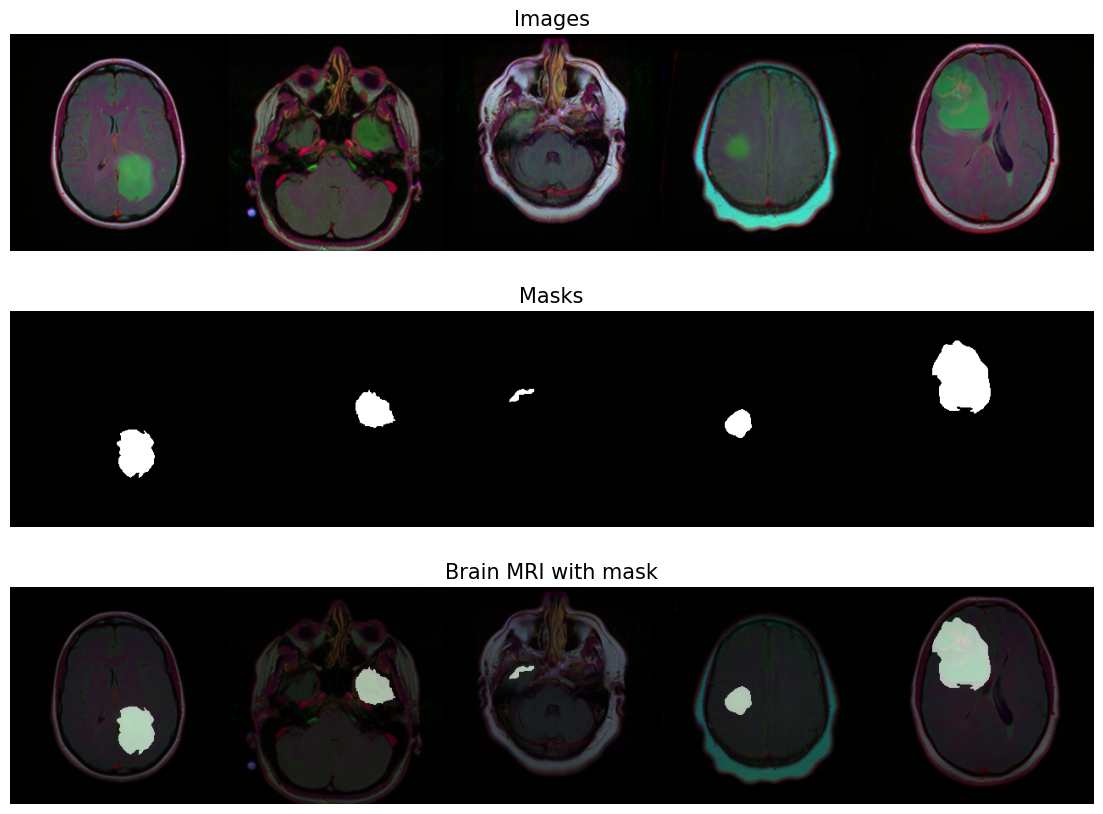

In [ ]:
set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

set_seed()

# Prepare the images and masks
images, masks = [], []
df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)

# Reverse the order of images and masks
images = np.array(images[4::-1])
masks = np.array(masks[4::-1])

# Concatenate the images and masks horizontally
images_concat = np.hstack(images)
masks_concat = np.hstack(masks)

# Plot the images, masks, and overlays
fig = plt.figure(figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.6)

grid[0].imshow(images_concat)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')

grid[1].imshow(masks_concat)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images_concat)
grid[2].imshow(masks_concat, alpha=0.6)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

plt.show()

In [ ]:
# Custom PyTorch Dataset class for loading images and masks from a DataFrame.
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [ ]:
# Define transformations for training, validation, and testing datasets using Albumentations library.
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    A.VerticalFlip(p=0.5),  # Apply vertical flip with 50% probability
    A.RandomRotate90(p=0.5),  # Rotate randomly by 90 degrees with 50% probability
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  # Randomly shift, scale, and rotate
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability (for data augmentation)
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
])

In [ ]:
# Setting seed for reproducibility across random processes.
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-20 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-14 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [ ]:
batch_size = 64

# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
# Fetch a batch of data (images and masks) from the training DataLoader (`train_dl`).
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


In [ ]:
# Defines the DoubleConv class, consisting of two consecutive
# convolutional layers each followed by BatchNorm and ReLU.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)


# Defines the Down class, which performs downscaling using MaxPool
# followed by DoubleConv.
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)


# Defines the Up class, which performs upscaling followed by DoubleConv.
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [ ]:
# Defines the UNet class, a convolutional neural network architecture
# for semantic segmentation.
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits

In [ ]:
# Instantiate the UNet model for semantic segmentation,
# with 3 input channels and 1 output channel (binary segmentation).
model = UNet(3, 1).to(device)

# Perform a forward pass through the model with a random input tensor
#of shape (1, 3, 128, 128), moved to the specified device (GPU or CPU).
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [ ]:
# Function to calculate the Dice coefficient metric between prediction and ground truth.
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [ ]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [ ]:
# Function to perform evaluation loop for the model.
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

In [ ]:
# Function to train the model and evaluate on validation data across epochs.
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [ ]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 30

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/30 |  Train Loss: 0.288, Val Loss: 0.266, Train DICE: 0.747, Val DICE: 0.931
Epoch: 2/30 |  Train Loss: 0.258, Val Loss: 0.267, Train DICE: 0.773, Val DICE: 0.932
Epoch: 3/30 |  Train Loss: 0.245, Val Loss: 0.255, Train DICE: 0.784, Val DICE: 0.940
Epoch: 4/30 |  Train Loss: 0.261, Val Loss: 0.341, Train DICE: 0.770, Val DICE: 0.868
Epoch: 5/30 |  Train Loss: 0.245, Val Loss: 0.335, Train DICE: 0.785, Val DICE: 0.868
Epoch: 6/30 |  Train Loss: 0.250, Val Loss: 0.264, Train DICE: 0.780, Val DICE: 0.933
Epoch: 7/30 |  Train Loss: 0.245, Val Loss: 0.333, Train DICE: 0.784, Val DICE: 0.866
Epoch: 8/30 |  Train Loss: 0.226, Val Loss: 0.231, Train DICE: 0.802, Val DICE: 0.963
Epoch: 9/30 |  Train Loss: 0.213, Val Loss: 0.218, Train DICE: 0.812, Val DICE: 0.975
Epoch: 10/30 |  Train Loss: 0.206, Val Loss: 0.218, Train DICE: 0.819, Val DICE: 0.974
Epoch: 11/30 |  Train Loss: 0.207, Val Loss: 0.214, Train DICE: 0.818, Val DICE: 0.978
Epoch: 12/30 |  Train Loss: 0.204, Val Loss: 0.211, 

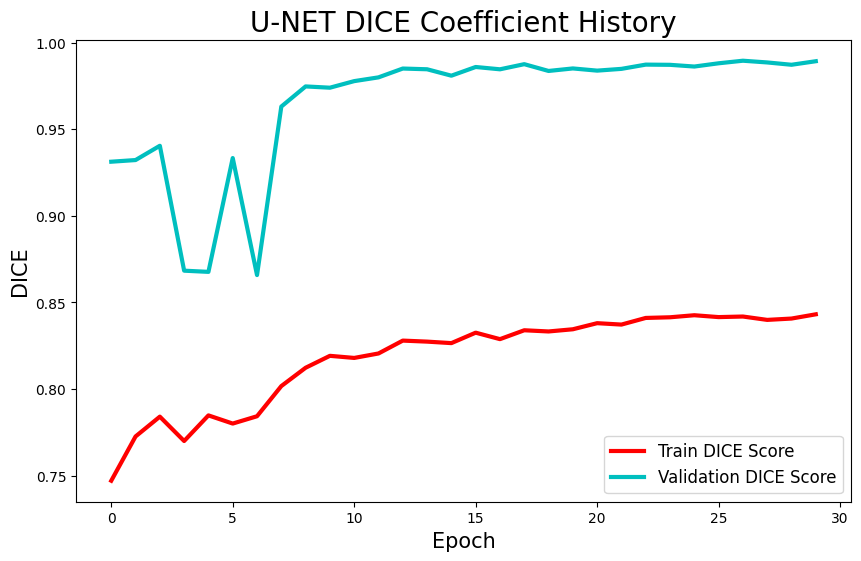

In [ ]:
# Function to plot Dice coefficient history across epochs.
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE Score', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE Score', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET DICE Coefficient History', train_dice_history, val_dice_history, num_epochs)

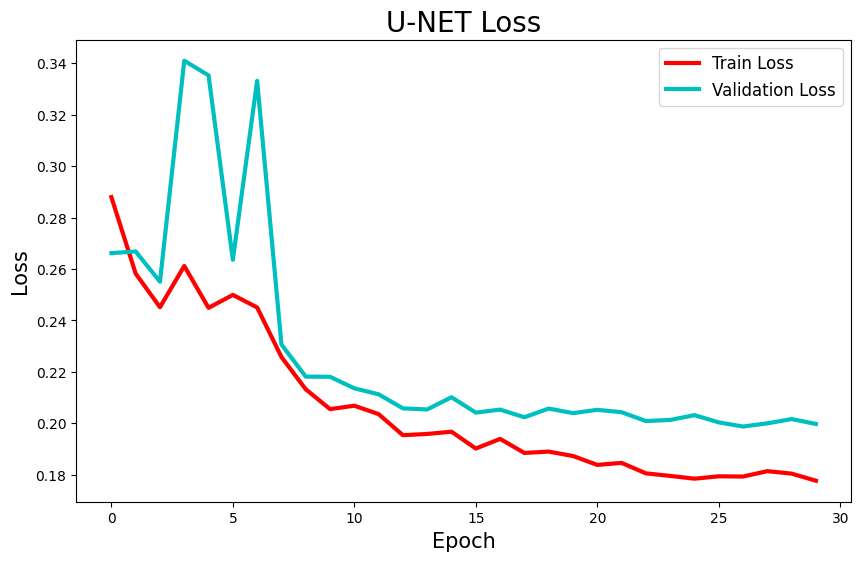

In [ ]:
# Function to plot loss history across epochs.
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="r")

    # Move val_loss_history to CPU and convert to NumPy array
    val_loss_history = [val_loss.cpu().detach().numpy() for val_loss in val_loss_history]
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

# Example usage to plot loss history for a UNet model
plot_loss_history('U-NET Loss', train_loss_history, val_loss_history, num_epochs)

In [ ]:
%%time
# Assuming eval_loop returns a tuple with more than 2 elements
results = eval_loop(model, test_dl, bce_dice_loss, training=False)

# Access the desired elements from the results tuple
test_dice = results[0]  # Assuming test_dice is the first element
test_loss = results[1]  # Assuming test_loss is the second element

print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean IoU/DICE: 98.873%, Loss: 0.200
CPU times: user 1.34 s, sys: 147 ms, total: 1.49 s
Wall time: 2.64 s


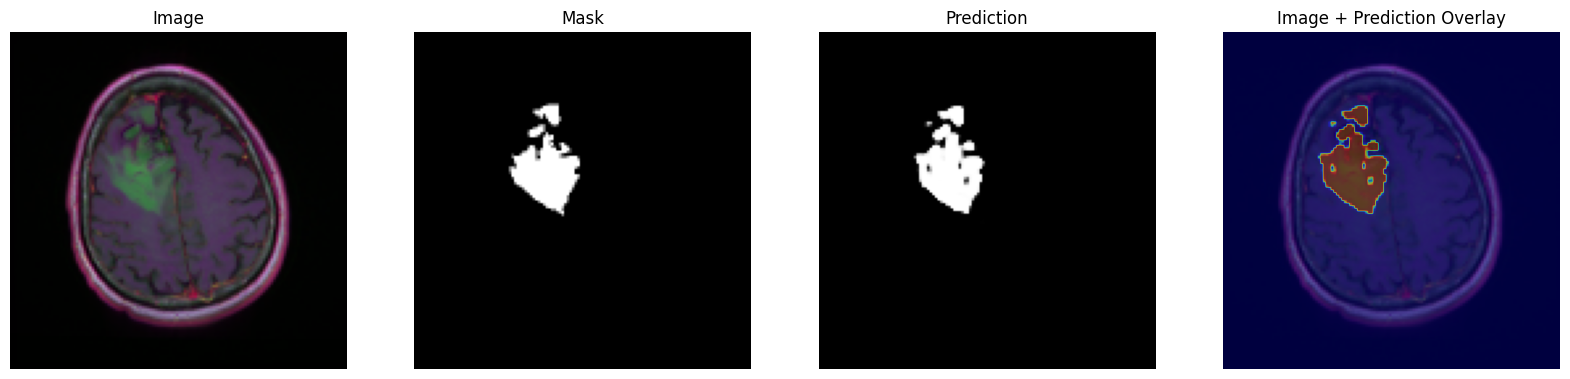

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(27).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Prediction
input_image = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
input_image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(input_image)
pred = model(input_image.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

# Create an overlay image
overlay = image.copy()
overlay[pred > 0.5, 1] = 255  # Green for prediction

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis('off')

ax[2].imshow(pred, cmap='gray')
ax[2].set_title("Prediction")
ax[2].axis('off')

ax[3].imshow(image)
ax[3].imshow(pred, cmap='jet', alpha=0.5)
ax[3].set_title("Image + Prediction Overlay")
ax[3].axis('off')

plt.show()

In [ ]:
## Saving the Model
torch.save(model.state_dict(), 'brain-mri-unet.pth')